In [84]:
# ===== 0) Reset & Imports =====
# 환경 설정: tf_env 사용
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [85]:
# Python 환경 확인
import sys
print("Python 경로:", sys.executable)
print("Python 버전:", sys.version)

# 설치된 패키지 확인
try:
    import tensorflow as tf
    print("TensorFlow 버전:", tf.__version__)
except ImportError as e:
    print("TensorFlow 임포트 실패:", e)
    
# pip 경로 확인
import subprocess
result = subprocess.run([sys.executable, '-m', 'pip', 'list'], capture_output=True, text=True)
print("\n설치된 패키지 일부:")
for line in result.stdout.split('\n')[:10]:
    if 'tensor' in line.lower():
        print(line)

Python 경로: /opt/anaconda3/envs/tf_env/bin/python
Python 버전: 3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 08:47:03) [Clang 18.1.8 ]
TensorFlow 버전: 2.18.0

설치된 패키지 일부:

설치된 패키지 일부:


In [86]:
# 완전 초기화
try: del model
except: pass
gc.collect()
keras.backend.clear_session()
np.random.seed(42); tf.random.set_seed(42)


In [87]:
# ===== 1) Config =====
# Use the repo-local TFLite-ready CSV so feature names/order match mobile assets
# Use absolute paths so notebook runs reliably regardless of working directory
# Set these to your repo path — change if your project is elsewhere on disk
DATA_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_data_tflite_ready.csv"
TARGET = "status"
BATCH_SIZE, EPOCHS = 32, 50 #배치 에폭 
# LABEL_MODE selects training target: 'soft' uses probability labels, 'binary' uses 0/1, 'both' keeps both and defaults to soft training
LABEL_MODE = 'both'  # options: 'soft' | 'binary' | 'both'
# APPLY_SAMPLE_WEIGHT: when True we'll down-weight samples with labels near 0.5 (uncertain).
# If you want to preserve 0.5 exactly and not reduce its influence, set this to False
APPLY_SAMPLE_WEIGHT = False #필요에 따라 수정
# EARLY_STOP_AT_ACC = 0.99
# LABEL_NA_POLICY controls how rows with missing/invalid label_soft are handled
# options: 'drop' (remove rows), 'impute' (fill with median), 'raise' (error out)
LABEL_NA_POLICY = 'drop'
# If using 'impute', this value will be used (median recommended)
LABEL_NA_IMPUTE_VALUE = None
# ===== 2) Load & Clean =====
df = pd.read_csv(DATA_PATH)
if "url" in df.columns: df = df.drop(columns=["url"])
df = shuffle(df, random_state=42)

In [88]:
# 라벨 정리 (soft-first 안전 처리) — soft 라벨을 우선 보존합니다
# 1) 표준화: 문자열 정리 및 명시적 매핑
tmp = df[TARGET].astype(str).str.strip().str.lower()
mapping = {'legitimate': '0', 'phishing': '1', 'zero': '0', 'one': '1'}
tmp = tmp.replace(mapping)
# 2) 숫자로 안전하게 변환 — invalid는 NaN으로 처리
df['label_soft'] = pd.to_numeric(tmp, errors='coerce').astype('float32')
# 3) NaN / 범위 검사
n_missing = int(df['label_soft'].isna().sum())
print('label_soft NaNs:', n_missing)
if 'LABEL_NA_POLICY' in globals():
    print('LABEL_NA_POLICY =', LABEL_NA_POLICY)
if n_missing > 0:
    if LABEL_NA_POLICY == 'drop':
        print(f'Dropping {n_missing} rows with missing labels')
        df = df.dropna(subset=['label_soft']).reset_index(drop=True)
    elif LABEL_NA_POLICY == 'impute':
        if LABEL_NA_IMPUTE_VALUE is None:
            fill = float(df['label_soft'].median())
        else:
            fill = float(LABEL_NA_IMPUTE_VALUE)
        print('Imputing missing labels with', fill)
        df['label_soft'] = df['label_soft'].fillna(fill)
    elif LABEL_NA_POLICY == 'raise':
        raise ValueError('Found missing labels (label_soft) and LABEL_NA_POLICY==raise')
# 4) Ensure label range is [0,1] — clip with warning if out of bounds
minv, maxv = df['label_soft'].min(), df['label_soft'].max()
if minv < 0 or maxv > 1:
    print('Warning: label_soft out of [0,1] range — clipping')
    df['label_soft'] = df['label_soft'].clip(0.0, 1.0)
print('label_soft min/max/mean:', df['label_soft'].min(), df['label_soft'].max(), df['label_soft'].mean())
# 5) hard binary label 생성 (앱/배포 호환성 용도)
df['label_binary'] = (df['label_soft'] >= 0.5).astype('float32')
print('Label counts (soft approx) top:', df['label_soft'].value_counts().head(10).to_dict())
print('Label counts (binary):', df['label_binary'].value_counts().to_dict())
# Note: we keep both label_soft and label_binary in the dataframe; training target selection controlled by LABEL_MODE

label_soft NaNs: 0
LABEL_NA_POLICY = drop
label_soft min/max/mean: 0.0 1.0 0.5000436
Label counts (soft approx) top: {1.0: 5741, 0.0: 5740}
Label counts (binary): {1.0: 5741, 0.0: 5740}


In [89]:
# ===== 3) 숫자 피처만 안전하게 선택 =====
# Exclude the target and any internal label columns we created earlier (label_soft, label_binary)
exclude_cols = {TARGET, 'label_soft', 'label_binary'}
feature_cols = [c for c in df.columns if c not in exclude_cols]
numeric_cols = []
for c in feature_cols:
    ser = pd.to_numeric(df[c], errors="coerce")
    if ser.notna().any():           # 전부 NaN이 아니면 사용
        df[c] = ser
        numeric_cols.append(c)

assert len(numeric_cols) > 0, "사용 가능한 숫자 피처가 없습니다."
# # --- Debugging output: show exactly which feature columns were candidates and which numeric columns were selected
# print('\n=== Feature selection summary ===')
# print('total df columns:', len(df.columns))
# # show excluded columns, and whether they are present in the current dataframe
# print('excluded columns (target + internal labels):', sorted(list(exclude_cols)))
# present_excluded = [c for c in exclude_cols if c in df.columns]
# missing_excluded = [c for c in exclude_cols if c not in df.columns]
# print('excluded_present_in_df:', present_excluded)
# print('excluded_missing_in_df:', missing_excluded)
# print('feature candidate columns (feature_cols) count:', len(feature_cols))
# print('feature candidate preview (first 20):', feature_cols[:20])
# print('numeric columns selected (numeric_cols) count:', len(numeric_cols))
# print('numeric columns selected:', numeric_cols)
# label_in_numeric = [c for c in numeric_cols if c in (TARGET, 'label_soft', 'label_binary')]
# if label_in_numeric:
#     print('WARNING: numeric_cols unexpectedly contains label-like columns:', label_in_numeric)
# else:
#     print('OK: no internal label columns are present in numeric_cols')

In [90]:
# 결측치 중앙값으로 채우기
for c in numeric_cols:
    med = float(df[c].dropna().median()) if df[c].notna().any() else 0.0
    df[c] = df[c].fillna(med).astype("float32")

# ===== 4) 행렬(X, y)로 변환 =====
X = df[numeric_cols].to_numpy(dtype="float32")
# Prepare soft and binary targets — do not overwrite original soft values
y_soft = df['label_soft'].to_numpy(dtype="float32")
y_binary = df['label_binary'].to_numpy(dtype="float32")
# Choose training target based on LABEL_MODE (soft | binary | both). 'both' will train using soft by default
if LABEL_MODE == 'soft':
    y = y_soft
elif LABEL_MODE == 'binary':
    y = y_binary
else:  # 'both' default to soft for training but keep binary for evaluation/export
    y = y_soft


# Use index-based split so soft and binary targets align with the same train/validation indices
# Ensure no NaNs in the stratify label (y_binary). If any appear, drop those rows first
mask_valid = ~np.isnan(y_binary)
if not mask_valid.all():
    n_bad = int((~mask_valid).sum())
    print(f'Warning: {n_bad} rows with NaN binary label found. Dropping before split.')
    X = X[mask_valid]
    y_soft = y_soft[mask_valid]
    y_binary = y_binary[mask_valid]
indices = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=y_binary, random_state=42)
X_train, X_val = X[train_idx], X[val_idx]
# aligned splits for both target types
y_soft_train, y_soft_val = y_soft[train_idx], y_soft[val_idx]
y_binary_train, y_binary_val = y_binary[train_idx], y_binary[val_idx]
if LABEL_MODE == 'soft':
    y_train, y_val = y_soft_train, y_soft_val
elif LABEL_MODE == 'binary':
    y_train, y_val = y_binary_train, y_binary_val
else:  # both - default to soft training, keep binary for evaluation
    y_train, y_val = y_soft_train, y_soft_val

print("X_train:", X_train.shape, " | X_val:", X_val.shape, " | n_features:", X_train.shape[1])

X_train: (9184, 79)  | X_val: (2297, 79)  | n_features: 79


In [91]:
# ===== PRE-TRAIN CHECKS =====
import os, json, numpy as np
print('Pre-train checks — shapes & metadata')
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('n_features (numeric_cols):', len(numeric_cols))
if X_train.shape[1] != len(numeric_cols):
    raise AssertionError(f'ERROR: feature column count mismatch: X_train has {X_train.shape[1]} cols but numeric_cols lists {len(numeric_cols)}')
# Compare to existing feature_info in repo/app assets if present
fi_paths = ['phishing/feature_info.json', 'app/src/main/assets/feature_info.json', '../app/src/main/assets/feature_info.json']
for p in fi_paths:
    if os.path.exists(p):
        try:
            with open(p) as f:
                fi = json.load(f)
            input_shape = fi.get('input_shape')
            feat_cols = fi.get('feature_columns', [])
            print(f'Found {p}: input_shape={input_shape}, feature_columns={len(feat_cols)}')
            if isinstance(input_shape, (list, tuple)) and len(input_shape) > 0 and input_shape[0] != X_train.shape[1]:
                print(f'WARNING: {p} input_shape[0] ({input_shape[0]}) != n_features ({X_train.shape[1]})')
        except Exception as e:
            print('Could not read', p, e)
# basic label distribution checks
print('y_soft_train min/max/mean:', np.min(y_soft_train), np.max(y_soft_train), np.mean(y_soft_train))
print('y_binary_train counts:', np.unique(y_binary_train, return_counts=True))
# sample_weight sanity if enabled (applies when training on soft labels)
if APPLY_SAMPLE_WEIGHT and LABEL_MODE in ('soft', 'both'):
    sw = np.clip(np.abs(y_train - 0.5) * 2.0, 0.1, 1.0)
    print('sample_weight min/max/mean:', sw.min(), sw.max(), sw.mean())
print('Pre-train checks done — proceed to model creation if OK')

Pre-train checks — shapes & metadata
X_train shape: (9184, 79)
X_val shape: (2297, 79)
n_features (numeric_cols): 79
Found ../app/src/main/assets/feature_info.json: input_shape=[79], feature_columns=79
y_soft_train min/max/mean: 0.0 1.0 0.5
y_binary_train counts: (array([0., 1.], dtype=float32), array([4592, 4592]))
Pre-train checks done — proceed to model creation if OK


In [92]:
# ===== 5) 모델 (단일 입력) =====
inp = keras.Input(shape=(X_train.shape[1],), name="features", dtype=tf.float32)
norm = layers.Normalization(name="norm_all")
norm.adapt(X_train)

x = norm(inp)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.1)(x)
out = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inp, outputs=out, name="phish_numeric_only")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")]
)
model.summary()

Model: "phish_numeric_only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm_all (Normalization)        │ (None, 79)             │           159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392 (28.88 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 159 (640.00 B)

In [93]:
# ===== 6) 콜백 & 학습 =====
# class StopAtAcc(keras.callbacks.Callback):
#     def __init__(self, target=EARLY_STOP_AT_ACC): super().__init__(); self.target=target
#     def on_epoch_end(self, epoch, logs=None):
#         if logs and logs.get("accuracy",0) >= self.target:
#             print(f"\nReached {self.target*100:.0f}% accuracy — stopping.")
#             self.model.stop_training = True

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     callbacks=[StopAtAcc()]
# )
# EarlyStopping 콜백을 주석 처리합니다 — 필요 시 다시 활성화하세요.
# es = keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True
# )

# Prepare sample weights when using soft labels — optional. Set APPLY_SAMPLE_WEIGHT=True to enable.
sample_weight = None
val_sample_weight = None
if LABEL_MODE == 'soft' and APPLY_SAMPLE_WEIGHT:
    # down-weight samples whose soft label is near 0.5 (uncertain).
    sw = np.abs(y_train - 0.5) * 2.0  # maps distance to 0..1
    sw = np.clip(sw, 0.1, 1.0)  # floor to avoid zero weights
    sample_weight = sw
    vsw = np.abs(y_val - 0.5) * 2.0
    val_sample_weight = np.clip(vsw, 0.1, 1.0)
    print('Sample weight [train] min/max/mean:', sample_weight.min(), sample_weight.max(), sample_weight.mean())
elif LABEL_MODE == 'soft':
    print('APPLY_SAMPLE_WEIGHT is False: training will use soft labels directly (0.5 included)')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val, val_sample_weight) if val_sample_weight is not None else (X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    # EarlyStopping disabled — callbacks list left empty intentionally
    callbacks=[],
    sample_weight=sample_weight,
    verbose=1,
)

Epoch 1/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8371 - loss: 0.3676 - val_accuracy: 0.8964 - val_loss: 0.2557
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - accuracy: 0.8371 - loss: 0.3676 - val_accuracy: 0.8964 - val_loss: 0.2557
Epoch 2/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.9076 - loss: 0.2372 - val_accuracy: 0.9108 - val_loss: 0.2250
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.9076 - loss: 0.2372 - val_accuracy: 0.9108 - val_loss: 0.2250
Epoch 3/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.9194 - loss: 0.2094 - val_accuracy: 0.9177 - val_loss: 0.2109
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.9194 - loss: 0.2094 - val_accuracy: 0.9177 - val_loss: 0.2109
Epoch 4/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.9263 - loss: 0.1938 - val_accuracy: 0.9269 - val_loss: 0.1998
Epoch 5/50
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.9263 - loss: 0.1938 - 

In [94]:
# ===== EVAL: validation metrics (soft & binary aware) =====
import numpy as np
from sklearn.metrics import roc_auc_score
# predict probabilities
preds = model.predict(X_val).flatten()
eps = 1e-7
preds_clipped = np.clip(preds, eps, 1.0 - eps)
# decide which true labels to use
if LABEL_MODE == 'soft':
    y_true_soft = y_val
    y_true_binary = (y_val >= 0.5).astype('float32')
elif LABEL_MODE == 'binary':
    y_true_binary = y_val
    y_true_soft = y_soft_val if 'y_soft_val' in globals() else y_true_binary.astype('float32')
else:  # both
    y_true_soft = y_soft_val
    y_true_binary = y_binary_val
# logloss (works with soft targets)
logloss = -np.mean(y_true_soft * np.log(preds_clipped) + (1 - y_true_soft) * np.log(1 - preds_clipped))
# AUC & Accuracy (binary metrics)
auc = roc_auc_score(y_true_binary, preds)
acc = np.mean((preds >= 0.5).astype('float32') == y_true_binary)
print('Validation results: logloss={:.6f}, AUC={:.4f}, accuracy={:.4f}'.format(logloss, auc, acc))
print('preds mean/min/max:', preds.mean(), preds.min(), preds.max())
print('soft-label stats: min/max/mean', y_true_soft.min(), y_true_soft.max(), y_true_soft.mean())

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
Validation results: logloss=0.144978, AUC=0.9898, accuracy=0.9608
preds mean/min/max: 0.49977952 1.9314475e-19 1.0
soft-label stats: min/max/mean 0.0 1.0 0.5002177
Validation results: logloss=0.144978, AUC=0.9898, accuracy=0.9608
preds mean/min/max: 0.49977952 1.9314475e-19 1.0
soft-label stats: min/max/mean 0.0 1.0 0.5002177


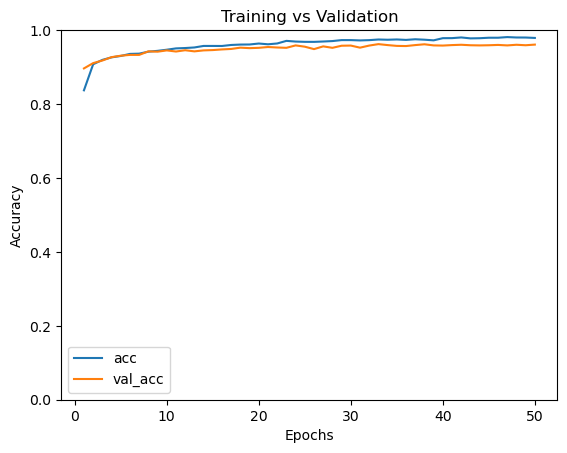

In [95]:
# ===== 7) Plot =====
# acc = history.history.get("accuracy", []); val_acc = history.history.get("val_accuracy", [])
# plt.figure(); plt.plot(range(1,len(acc)+1), acc, label="acc"); plt.plot(range(1,len(val_acc)+1), val_acc, label="val_acc")
# plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Training vs Validation"); plt.show()

acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
epochs = range(1, len(acc) + 1)

plt.figure()
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.ylim(0, 1)                         # 🔁 변경점 4: 축 고정으로 왜곡 방지
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Training vs Validation")
plt.legend(); plt.show()

In [97]:
# ===== 8) TFLite 변환 =====
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# TFLite 모델 저장
# Save outputs into the repo-local phishing/ folder
# Use absolute paths for outputs to ensure we write into the repo phishing/ folder
tflite_path = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_model.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite 모델이 저장되었습니다: {tflite_path}")

# 피처 정보 저장 (Android에서 사용)
import json
# Export feature_info with labeling metadata so the app can handle soft labels & uncertainty
feature_info = {
    "feature_columns": numeric_cols,
    "input_shape": [X_train.shape[1]],
    "normalization_layer": "norm_all",
    "labeling": LABEL_MODE,  # 'soft'|'binary'|'both'
    "uncertainty_notify_eps": 0.05  # app should flag predictions in [0.5-eps, 0.5+eps] as low confidence
}

feature_info_path = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/feature_info.json"
with open(feature_info_path, 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"피처 정보가 저장되었습니다: {feature_info_path}")

INFO:tensorflow:Assets written to: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpranic59x/assets


INFO:tensorflow:Assets written to: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpranic59x/assets


Saved artifact at '/var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpranic59x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 79), dtype=tf.float32, name='features')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13383636304: TensorSpec(shape=(1, 79), dtype=tf.float32, name=None)
  13383644560: TensorSpec(shape=(1, 79), dtype=tf.float32, name=None)
  13383642640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13383642832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13383633616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13383632464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13383640720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13383646480: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite 모델이 저장되었습니다: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_model.tflite
피처 정보가 저장되었습니다: /Users/seungmin/AndroidStud

W0000 00:00:1763743083.090194 4171299 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1763743083.090206 4171299 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-11-22 01:38:03.090296: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpranic59x
2025-11-22 01:38:03.090529: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-22 01:38:03.090533: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpranic59x
2025-11-22 01:38:03.093223: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-22 01:38:03.108580: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpranic59x
2025-11-22 01:38:03.113224: I tensorflow/cc/saved_model/loader.cc: